/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


hello GPU
Using 2 GPUs
INFO: Restoring checkpoint for D...
INFO: Restoring checkpoint for G...
INFO: Starting training from global step 100000...


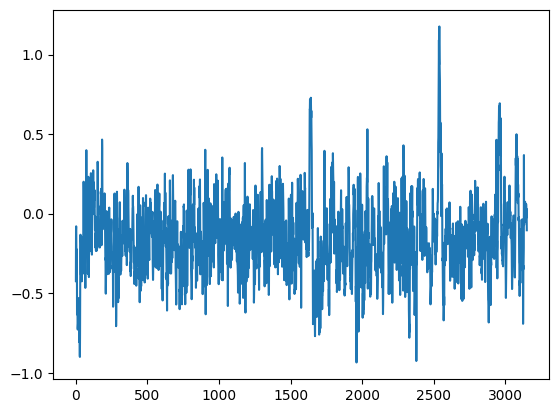

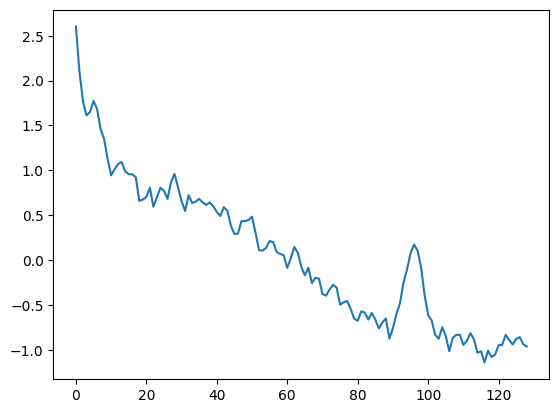

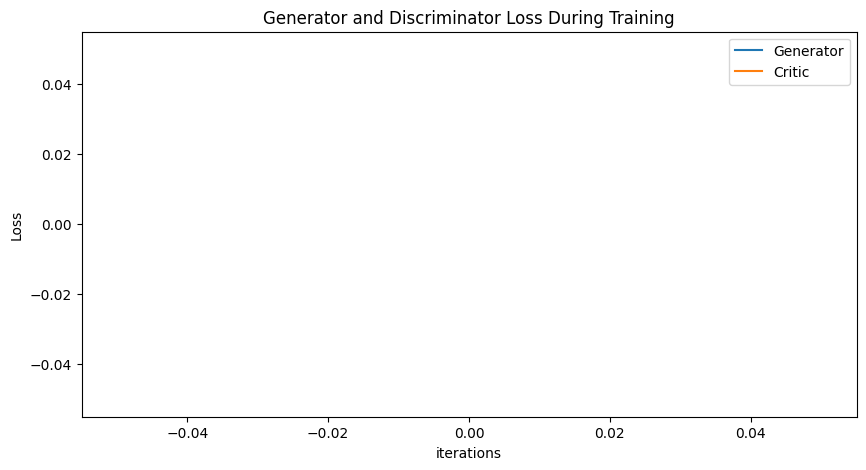

INFO: Saving checkpoints from keyboard interrupt...
INFO: Training Ended.


In [4]:



import numpy as np
import torch
import torch.nn as nn
from torch import autograd
from torch.nn.parameter import Parameter
from scipy.signal import welch
from torch.autograd import Variable

"""
Loss functions definitions.
"""
import torch
import torch.nn.functional as F



def _bce_loss_with_logits(output, labels, **kwargs):
    r"""
    Wrapper for BCE loss with logits.
    """
    return F.binary_cross_entropy_with_logits(output, labels, **kwargs)


def minimax_loss_gen(output_fake, real_label_val=1.0, **kwargs):
    r"""
    Standard minimax loss for GANs through the BCE Loss with logits fn.

    Args:
        output (Tensor): Discriminator output logits.
        labels (Tensor): Labels for computing cross entropy.

    Returns:
        Tensor: A scalar tensor loss output.
    """
    # Produce real labels so G is rewarded if D is fooled
    real_labels = torch.full((output_fake.shape[0], 1),
                             real_label_val,
                             device=output_fake.device)

    loss = _bce_loss_with_logits(output_fake, real_labels, **kwargs)

    return loss


def minimax_loss_dis(output_fake,
                     output_real,
                     real_label_val=1.0,
                     fake_label_val=0.0,
                     **kwargs):
    r"""
    Standard minimax loss for GANs through the BCE Loss with logits fn.

    Args:
        output_fake (Tensor): Discriminator output logits for fake signals.
        output_real (Tensor): Discriminator output logits for real signals.
        real_label_val (int): Label for real signals.
        fake_label_val (int): Label for fake signals.
        device (torch.device): Torch device object for sending created data.

    Returns:
        Tensor: A scalar tensor loss output.
    """
    # Produce real and fake labels.
    fake_labels = torch.full((output_fake.shape[0], 1),
                             fake_label_val,
                             device=output_fake.device)
    real_labels = torch.full((output_real.shape[0], 1),
                             real_label_val,
                             device=output_real.device)

    # FF, compute loss and backprop D
    errD_fake = _bce_loss_with_logits(output=output_fake,
                                      labels=fake_labels,
                                      **kwargs)

    errD_real = _bce_loss_with_logits(output=output_real,
                                      labels=real_labels,
                                      **kwargs)

    # Compute cumulative error
    loss = errD_real + errD_fake

    return loss


def ns_loss_gen(output_fake):
    r"""
    Non-saturating loss for generator.

    Args:
        output_fake (Tensor): Discriminator output logits for fake signals.

    Returns:
        Tensor: A scalar tensor loss output.
    """
    output_fake = torch.sigmoid(output_fake)

    return -torch.mean(torch.log(output_fake + 1e-8))


def wasserstein_loss_dis(output_real, output_fake):
    r"""
    Computes the wasserstein loss for the discriminator.

    Args:
        output_real (Tensor): Discriminator output logits for real signals.
        output_fake (Tensor): Discriminator output logits for fake signals.

    Returns:
        Tensor: A scalar tensor loss output.
    """
    loss = -1.0 * output_real.mean() + output_fake.mean()

    return loss


def wasserstein_loss_gen(output_fake):
    r"""
    Computes the wasserstein loss for generator.

    Args:
        output_fake (Tensor): Discriminator output logits for fake signals.

    Returns:
        Tensor: A scalar tensor loss output.
    """
    loss = -output_fake.mean()

    return loss


def hinge_loss_dis(output_fake, output_real):
    r"""
    Hinge loss for discriminator.

    Args:
        output_fake (Tensor): Discriminator output logits for fake signals.
        output_real (Tensor): Discriminator output logits for real signals.

    Returns:
        Tensor: A scalar tensor loss output.
    """
    loss = F.relu(1.0 - output_real).mean() + \
           F.relu(1.0 + output_fake).mean()

    return loss


def hinge_loss_gen(output_fake):
    r"""
    Hinge loss for generator.

    Args:
        output_fake (Tensor): Discriminator output logits for fake signals.

    Returns:
        Tensor: A scalar tensor loss output.
    """
    loss = -output_fake.mean()

    return loss


import os
import re
import time
import matplotlib.pyplot as plt
import numpy as np

import torch

"""
Implementation of the Logger object for performing training logging and visualisation.
"""
import os

import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
from torchvision import utils as vutils


class Logger:
    """
    Writes summaries and visualises training progress.

    Attributes:
        log_dir (str): The path to store logging information.
        num_steps (int): Total number of training iterations.
        dataset_size (int): The number of examples in the dataset.
        device (Device): Torch device object to send data to.
        flush_secs (int): Number of seconds before flushing summaries to disk.
        writers (dict): A dictionary of tensorboard writers with keys as metric names.
        num_epochs (int): The number of epochs, for extra information.
    """
    def __init__(self,
                 log_dir,
                 num_steps,
                 dataset_size,
                 device,
                 flush_secs=120,
                 **kwargs):
        self.log_dir = log_dir
        self.num_steps = num_steps
        self.dataset_size = dataset_size
        self.flush_secs = flush_secs
        self.num_epochs = self._get_epoch(num_steps)
        self.device = device
        self.writers = {}

        # Create log directory if haven't already
        if not os.path.exists(self.log_dir):
            os.makedirs(self.log_dir)

    def _get_epoch(self, steps):
        """
        Helper function for getting epoch.
        """
        return max(int(steps / self.dataset_size), 1)

    def _build_writer(self, metric):
        writer = SummaryWriter(log_dir=os.path.join(self.log_dir, 'data',
                                                    metric),
                               flush_secs=self.flush_secs)

        return writer

    def write_summaries(self, log_data, global_step):
        """
        Tasks appropriate writers to write the summaries in tensorboard. Creates additional
        writers for summary writing if there are new scalars to log in log_data.

        Args:
            log_data (MetricLog): Dict-like object to collect log data for TB writing.
            global_step (int): Global step variable for syncing logs.

        Returns:
            None
        """
        for metric, data in log_data.items():
            if metric not in self.writers:
                self.writers[metric] = self._build_writer(metric)

            # Write with a group name if it exists
            name = log_data.get_group_name(metric) or metric
            self.writers[metric].add_scalar(name,
                                            log_data[metric],
                                            global_step=global_step)

    def close_writers(self):
        """
        Closes all writers.
        """
        for metric in self.writers:
            self.writers[metric].close()

    def print_log(self, global_step, log_data, time_taken):
        """
        Formats the string to print to stdout based on training information.

        Args:
            log_data (MetricLog): Dict-like object to collect log data for TB writing.
            global_step (int): Global step variable for syncing logs.
            time_taken (float): Time taken for one training iteration.

        Returns:
            str: String to be printed to stdout.
        """
        # Basic information
        log_to_show = [
            "INFO: [Epoch {:d}/{:d}][Global Step: {:d}/{:d}]".format(
                self._get_epoch(global_step), self.num_epochs, global_step,
                self.num_steps)
        ]

        # Display GAN information as fed from user.
        GAN_info = [""]
        metrics = sorted(log_data.keys())

        for metric in metrics:
            GAN_info.append('{}: {}'.format(metric, log_data[metric]))

        # Add train step time information
        GAN_info.append("({:.4f} sec/idx)".format(time_taken))

        # Accumulate to log
        log_to_show.append("\n| ".join(GAN_info))

        # Finally print the output
        ret = " ".join(log_to_show)
        print(ret)

        return ret

    def _get_fixed_noise(self, nz, num_signals, output_dir=None):
        """
        Produce the fixed gaussian noise vectors used across all models
        for consistency.
        """
        if output_dir is None:
            output_dir = os.path.join(self.log_dir, 'viz')

        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        output_file = os.path.join(output_dir,
                                   'fixed_noise_nz_{}.pth'.format(nz))

        if os.path.exists(output_file):
            noise = torch.load(output_file)

        else:
            noise = torch.randn((num_signals, nz))
            torch.save(noise, output_file)

        return noise.to(self.device)

    def _get_fixed_labels(self, num_signals, num_classes):
        """
        Produces fixed class labels for generating fixed signals.
        """
        labels = np.array([i % num_classes for i in range(num_signals)])
        labels = torch.from_numpy(labels).to(self.device)

        return labels

    def vis_signals(self, netG, global_step, num_signals=64):
        """
        Produce visualisations of the G(z), one fixed and one random.

        Args:
            netG (Module): Generator model object for producing signals.
            global_step (int): Global step variable for syncing logs.
            num_signals (int): The number of signals to visualise.

        Returns:
            None
        """
        img_dir = os.path.join(self.log_dir, 'signals')
        if not os.path.exists(img_dir):
            os.makedirs(img_dir)

        with torch.no_grad():
            # Generate random signals
            noise = torch.randn((num_signals, netG.nz), device=self.device)
            fake_signals = netG(noise).detach().cpu()

            # Generate fixed random signals
            fixed_noise = self._get_fixed_noise(nz=netG.nz,
                                                num_signals=num_signals)

            if hasattr(netG, 'num_classes') and netG.num_classes > 0:
                fixed_labels = self._get_fixed_labels(num_signals,
                                                      netG.num_classes)
                fixed_fake_signals = netG(fixed_noise,
                                         fixed_labels).detach().cpu()
            else:
                fixed_fake_signals = netG(fixed_noise).detach().cpu()

            # Map name to results
            signals_dict = {
                'fixed_fake': fixed_fake_signals,
                'fake': fake_signals
            }

            # Visualise all results
            for name, signals in signals_dict.items():
                signals_viz = vutils.make_grid(signals,
                                              padding=2,
                                              normalize=True)

                vutils.save_signal(signals_viz,
                                  '{}/{}_samples_step_{}.png'.format(
                                      img_dir, name, global_step),
                                  normalize=True)

                if 'img' not in self.writers:
                    self.writers['img'] = self._build_writer('img')

                self.writers['img'].add_signal('{}_vis'.format(name),
                                              signals_viz,
                                              global_step=global_step)
"""
MetricLog object for intelligently logging data to display them more intuitively.
"""


class MetricLog:
    """
    A dictionary-like object that logs data, and includes an extra dict to map the metrics
    to its group name, if any, and the corresponding precision to print out.

    Attributes:
        metrics_dict (dict): A dictionary mapping to another dict containing
            the corresponding value, precision, and the group this metric belongs to.
    """
    def __init__(self, **kwargs):
        self.metrics_dict = {}

    def add_metric(self, name, value, group=None, precision=4):
        """
        Logs metric to internal dict, but with an additional option
        of grouping certain metrics together.

        Args:
            name (str): Name of metric to log.
            value (Tensor/Float): Value of the metric to log.
            group (str): Name of the group to classify different metrics together.
            precision (int): The number of floating point precision to represent the value.

        Returns:
            None
        """
        # Grab tensor values only
        try:
            value = value.item()
        except AttributeError:
            value = value

        self.metrics_dict[name] = dict(value=value,
                                       group=group,
                                       precision=precision)

    def __getitem__(self, key):
        return round(self.metrics_dict[key]['value'],
                     self.metrics_dict[key]['precision'])

    def get_group_name(self, name):
        """
        Obtains the group name of a particular metric. For example, errD and errG
        which represents the discriminator/generator losses could fall under a
        group name called "loss".

        Args:
            name (str): The name of the metric to retrieve group name.

        Returns:
            str: A string representing the group name of the metric.
        """
        return self.metrics_dict[name]['group']

    def keys(self):
        """
        Dict like functionality for retrieving keys.
        """
        return self.metrics_dict.keys()

    def items(self):
        """
        Dict like functionality for retrieving items.
        """
        return self.metrics_dict.items()
"""
Implementation of a specific learning rate scheduler for GANs.
"""


class LRScheduler:
    """
    Learning rate scheduler for training GANs. Supports GAN specific LR scheduling
    policies, such as the linear decay policy using in SN-GAN paper as based on the
    original chainer implementation. However, one could safely ignore this class
    and instead use the official PyTorch scheduler wrappers around a optimizer
    for other scheduling policies.

    Attributes:
        lr_decay (str): The learning rate decay policy to use.
        optD (Optimizer): Torch optimizer object for discriminator.
        optG (Optimizer): Torch optimizer object for generator.
        num_steps (int): The number of training iterations.
        lr_D (float): The initial learning rate of optD.
        lr_G (float): The initial learning rate of optG.
    """
    def __init__(self,
                 lr_decay,
                 optD,
                 optG,
                 num_steps,
                 start_step=0,
                 **kwargs):
        if lr_decay not in [None, 'None', 'linear']:
            raise NotImplementedError(
                "lr_decay {} is not currently supported.")

        self.lr_decay = lr_decay
        self.optD = optD
        self.optG = optG
        self.num_steps = num_steps
        self.start_step = start_step

        # Cache the initial learning rate for uses later
        self.lr_D = optD.param_groups[0]['lr']
        self.lr_G = optG.param_groups[0]['lr']

    def linear_decay(self, optimizer, global_step, lr_value_range,
                     lr_step_range):
        """
        Performs linear decay of the optimizer learning rate based on the number of global
        steps taken. Follows SNGAN's chainer implementation of linear decay, as seen in the
        chainer references:
        https://docs.chainer.org/en/stable/reference/generated/chainer.training.extensions.LinearShift.html
        https://github.com/chainer/chainer/blob/v6.2.0/chainer/training/extensions/linear_shift.py#L66

        Note: assumes that the optimizer has only one parameter group to update!

        Args:
            optimizer (Optimizer): Torch optimizer object to update learning rate.
            global_step (int): The current global step of the training.
            lr_value_range (tuple): A tuple of floats (x,y) to decrease from x to y.
            lr_step_range (tuple): A tuple of ints (i, j) to start decreasing
                when global_step > i, and until j.

        Returns:
            float: Float representing the new updated learning rate.
        """
        # Compute the new learning rate
        v1, v2 = lr_value_range
        s1, s2 = lr_step_range

        if global_step <= s1:
            updated_lr = v1

        elif global_step >= s2:
            updated_lr = v2

        else:
            scale_factor = (global_step - s1) / (s2 - s1)
            updated_lr = v1 + scale_factor * (v2 - v1)

        # Update the learning rate
        optimizer.param_groups[0]['lr'] = updated_lr

        return updated_lr

    def step(self, log_data, global_step):
        """
        Takes a step for updating learning rate and updates the input log_data
        with the current status.

        Args:
            log_data (MetricLog): Object for logging the updated learning rate metric.
            global_step (int): The current global step of the training.

        Returns:
            MetricLog: MetricLog object containing the updated learning rate at the current global step.
        """
        if self.lr_decay == "linear":
            lr_D = self.linear_decay(optimizer=self.optD,
                                     global_step=global_step,
                                     lr_value_range=(self.lr_D, 0.0),
                                     lr_step_range=(self.start_step,
                                                    self.num_steps))

            lr_G = self.linear_decay(optimizer=self.optG,
                                     global_step=global_step,
                                     lr_value_range=(self.lr_G, 0.0),
                                     lr_step_range=(self.start_step,
                                                    self.num_steps))

        elif self.lr_decay in [None, "None"]:
            lr_D = self.lr_D
            lr_G = self.lr_G

        # Update metrics log
        log_data.add_metric('lr_D', lr_D, group='lr', precision=6)
        log_data.add_metric('lr_G', lr_G, group='lr', precision=6)

        return log_data

"""
Script for common utility functions.
"""
import json
import os

import numpy as np
import torch
from skimage import io


def write_to_json(dict_to_write, output_file):
    """
    Outputs a given dictionary as a JSON file with indents.

    Args:
        dict_to_write (dict): Input dictionary to output.
        output_file (str): File path to write the dictionary.

    Returns:
        None
    """
    with open(output_file, 'w') as file:
        json.dump(dict_to_write, file, indent=4)


def load_from_json(json_file):
    """
    Loads a JSON file as a dictionary and return it.

    Args:
        json_file (str): Input JSON file to read.

    Returns:
        dict: Dictionary loaded from the JSON file.
    """
    with open(json_file, 'r') as file:
        return json.load(file)


def save_tensor_image(x, output_file):
    """
    Saves an input image tensor as some numpy array, useful for tests.

    Args:
        x (Tensor): A 3D tensor image of shape (3, H, W).
        output_file (str): The output image file to save the tensor.

    Returns:
        None
    """
    folder = os.path.dirname(output_file)
    if not os.path.exists(folder):
        os.makedirs(folder)

    x = x.permute(1, 2, 0).numpy()
    io.imsave(output_file, x)


def load_images(n=1, size=32):
    """
    Load n image tensors with some fake labels.

    Args:
        n (int): Number of random images to load.
        size (int): Spatial size of random image.

    Returns:
        Tensor: Random images of shape (n, 3, size, size) and 0-valued labels.
    """
    images = torch.randn(n, 3, size, size)
    labels = torch.from_numpy(np.array([0 * n]))

    return images, labels

class Trainer:
    """
    Trainer object for constructing the GAN training pipeline.

    Attributes:
        netD (Module): Torch discriminator model.
        netG (Module): Torch generator model.
        optD (Optimizer): Torch optimizer object for discriminator.
        optG (Optimizer): Torch optimizer object for generator.
        dataloader (DataLoader): Torch object for loading data from a dataset object.
        num_steps (int): The number of training iterations.
        n_dis (int): Number of discriminator update steps per generator training step.
        lr_decay (str): The learning rate decay policy to use.
        log_dir (str): The path to storing logging information and checkpoints.
        device (Device): Torch device object to send model/data to.
        logger (Logger): Logger object for visualising training information.
        scheduler (LRScheduler): GAN training specific learning rate scheduler object.
        params (dict): Dictionary of training hyperparameters.
        netD_ckpt_file (str): Custom checkpoint file to restore discriminator from.
        netG_ckpt_file (str): Custom checkpoint file to restore generator from.
        print_steps (int): Number of training steps before printing training info to stdout.
        vis_steps (int): Number of training steps before visualising images with TensorBoard.
        flush_secs (int): Number of seconds before flushing summaries to disk.
        log_steps (int): Number of training steps before writing summaries to TensorBoard.
        save_steps (int): Number of training steps bfeore checkpointing.
    """
    def __init__(self,
                 netD,
                 netG,
                 optD,
                 optG,
                 dataloader,
                 num_steps,
                 log_dir='./log',
                 n_dis=1,
                 lr_decay=None,
                 device=None,
                 netG_ckpt_file=None,
                 netD_ckpt_file=None,
                 print_steps=1,
                 vis_steps=500,
                 log_steps=50,
                 save_steps=5000,
                 flush_secs=30):
        # Input values checks
        ints_to_check = {
            'num_steps': num_steps,
            'n_dis': n_dis,
            'print_steps': print_steps,
            'vis_steps': vis_steps,
            'log_steps': log_steps,
            'save_steps': save_steps,
            'flush_secs': flush_secs
        }
        for name, var in ints_to_check.items():
            if var < 1:
                raise ValueError('{} must be at least 1 but got {}.'.format(
                    name, var))

        self.netD = netD
        self.netG = netG
        self.optD = optD
        self.optG = optG
        self.n_dis = n_dis
        self.lr_decay = lr_decay
        self.dataloader = dataloader
        self.num_steps = num_steps
        self.device = device
        self.log_dir = log_dir
        self.netG_ckpt_file = netG_ckpt_file
        self.netD_ckpt_file = netD_ckpt_file
        self.print_steps = print_steps
        self.vis_steps = vis_steps
        self.log_steps = log_steps
        self.save_steps = save_steps
        self.errG = []
        self.errD = []

        if not os.path.exists(self.log_dir):
            os.makedirs(self.log_dir)

        # Training helper objects
        self.logger = Logger(log_dir=self.log_dir,
                                    num_steps=self.num_steps,
                                    dataset_size=len(self.dataloader),
                                    flush_secs=flush_secs,
                                    device=self.device)

        self.scheduler = LRScheduler(lr_decay=self.lr_decay,
                                               optD=self.optD,
                                               optG=self.optG,
                                               num_steps=self.num_steps)

        # Obtain custom or latest checkpoint files
        if self.netG_ckpt_file:
            self.netG_ckpt_dir = os.path.dirname(netG_ckpt_file)
            self.netG_ckpt_file = netG_ckpt_file
        else:
            self.netG_ckpt_dir = os.path.join(self.log_dir, 'checkpoints',
                                              'netG')
            self.netG_ckpt_file = self._get_latest_checkpoint(
                self.netG_ckpt_dir)  # can be None

        if self.netD_ckpt_file:
            self.netD_ckpt_dir = os.path.dirname(netD_ckpt_file)
            self.netD_ckpt_file = netD_ckpt_file
        else:
            self.netD_ckpt_dir = os.path.join(self.log_dir, 'checkpoints',
                                              'netD')
            self.netD_ckpt_file = self._get_latest_checkpoint(
                self.netD_ckpt_dir)

        # Log hyperparameters for experiments
        self.params = {
            'log_dir': self.log_dir,
            'num_steps': self.num_steps,
            'batch_size': self.dataloader.batch_size,
            'n_dis': self.n_dis,
            'lr_decay': self.lr_decay,
            'optD': optD.__repr__(),
            'optG': optG.__repr__(),
            'save_steps': self.save_steps,
        }
        self._log_params(self.params)

        # Device for hosting model and data
        if not self.device:
            self.device = torch.device(
                'cuda:0' if torch.cuda.is_available() else "cpu")

        # Ensure model and data are in the same device
        for net in [self.netD, self.netG]:
            if net.device != self.device:
                net.to(self.device)
#         for net in [self.netD, self.netG]:
#             if next(net.parameters()).device != self.device:
#                 net.to(self.device)

    def _log_params(self, params):
        """
        Takes the argument options to save into a json file.
        """
        params_file = os.path.join(self.log_dir, 'params.json')

        # Check for discrepancy with previous training config.
        if os.path.exists(params_file):
            check = load_from_json(params_file)

            if params != check:
                diffs = []
                for k in params:
                    if k in check and params[k] != check[k]:
                        diffs.append('{}: Expected {} but got {}.'.format(
                            k, check[k], params[k]))

                diff_string = '\n'.join(diffs)
                raise ValueError(
                    "Current hyperparameter configuration is different from previously:\n{}"
                    .format(diff_string))

        write_to_json(params, params_file)

    def _get_latest_checkpoint(self, ckpt_dir):
        """
        Given a checkpoint dir, finds the checkpoint with the latest training step.
        """
        def _get_step_number(k):
            """
            Helper function to get step number from checkpoint files.
            """
            search = re.search(r'(\d+)_steps', k)

            if search:
                return int(search.groups()[0])
            else:
                return -float('inf')

        if not os.path.exists(ckpt_dir):
            return None

        files = os.listdir(ckpt_dir)
        if len(files) == 0:
            return None

        ckpt_file = max(files, key=lambda x: _get_step_number(x))

        return os.path.join(ckpt_dir, ckpt_file)

    def _fetch_data(self, iter_dataloader):
        """
        Fetches the next set of data and refresh the iterator when it is exhausted.
        Follows python EAFP, so no iterator.hasNext() is used.
        """
        try:
            real_batch = next(iter_dataloader)
        except StopIteration:
            iter_dataloader = iter(self.dataloader)
            real_batch = next(iter_dataloader)

        real_batch = real_batch[0].to(self.device)

        return real_batch

    def _restore_models_and_step(self):
        """
        Restores model and optimizer checkpoints and ensures global step is in sync.
        """
        global_step_D = global_step_G = 0

        if self.netD_ckpt_file and os.path.exists(self.netD_ckpt_file):
            print("INFO: Restoring checkpoint for D...")
            global_step_D = self.netD.restore_checkpoint(
                ckpt_file=self.netD_ckpt_file, optimizer=self.optD)

        if self.netG_ckpt_file and os.path.exists(self.netG_ckpt_file):
            print("INFO: Restoring checkpoint for G...")
            global_step_G = self.netG.restore_checkpoint(
                ckpt_file=self.netG_ckpt_file, optimizer=self.optG)

        if global_step_G != global_step_D:
            raise ValueError('G and D Networks are out of sync.')
        else:
            global_step = global_step_G  # Restores global step

        return global_step

    def _save_model_checkpoints(self, global_step):
        """
        Saves both discriminator and generator checkpoints.
        """
        self.netG.save_checkpoint(directory=self.netG_ckpt_dir,
                                  global_step=global_step,
                                  optimizer=self.optG)

        self.netD.save_checkpoint(directory=self.netD_ckpt_dir,
                                  global_step=global_step,
                                  optimizer=self.optD)





    def plot_everything(self, generated_data, gen_err, critic_err):
        def compute_psd(data, fs, nperseg=256, noverlap=None):
            """
            Compute Power Spectral Density (PSD) using the Welch method.

            Parameters:
                data (array): EEG data array with shape (n_channels, n_samples).
                fs (float): Sampling frequency.
                nperseg (int): Length of each segment for PSD estimation.
                noverlap (int): Number of overlapping samples between segments.

            Returns:
                freqs (array): Frequency values.
                psd (array): Power Spectral Density values.
            """
            n_channels, n_samples = data.shape
            psd = np.zeros((n_channels, nperseg // 2 + 1))

            for ch_idx in range(n_channels):
                f, Pxx = plt.psd(data[ch_idx], Fs=fs, NFFT=256, noverlap=128, window=np.hanning(256), scale_by_freq=True)
                # Add a small epsilon to avoid zero values
                psd[ch_idx] = Pxx + 1e-10

            return f, psd

        def average_across_arrays(generated_data):
            return generated_data.mean(dim=0)

        # Set the sampling frequency
        fs = 160.0

        generated_data = generated_data.detach()

        # plotting generated data
        values = generated_data[0, 0, :]
        plt.plot(values.tolist())
        plt.show()

        # plotting PSD
        averaged_data = average_across_arrays(generated_data)
        freqs, psd = compute_psd(averaged_data, fs)
        plt.figure(figsize=(10, 6))  # Add this line to create a single figure
        for ch_idx in range(1):
            plt.semilogy(freqs, psd[ch_idx], label=f'Channel {ch_idx + 1}')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power/Frequency (dB/Hz)')
        plt.show()

        # plotting G vs D losses
        plt.figure(figsize=(10,5))
        plt.title("Generator and Discriminator Loss During Training")
        plt.plot(gen_err,label="Generator")
        plt.plot(critic_err,label="Critic")
        plt.xlabel("iterations")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()




    def train(self):
        """
        Runs the training pipeline with all given parameters in Trainer.
        """
        # Restore models
        global_step = self._restore_models_and_step()
        print("INFO: Starting training from global step {}...".format(
            global_step))

        try:
            start_time = time.time()

            # Iterate through data
            iter_dataloader = iter(self.dataloader)
            while global_step < self.num_steps:
                log_data = MetricLog()  # log data for tensorboard

                # -------------------------
                #   One Training Step
                # -------------------------
                # Update n_dis times for D
                for i in range(self.n_dis):
                    real_batch = self._fetch_data(iter_dataloader=iter_dataloader)

                    # ------------------------
                    #   Update D Network
                    # -----------------------
                    log_data = self.netD.train_step(real_batch=real_batch,
                                                    netG=self.netG,
                                                    optD=self.optD,
                                                    log_data=log_data,
                                                    global_step=global_step,
                                                    device=self.device)

                    # -----------------------
                    #   Update G Network
                    # -----------------------
                    # Update G, but only once.
                    if i == (self.n_dis - 1):
                        log_data = self.netG.train_step(
                            real_batch=real_batch,
                            netD=self.netD,
                            optG=self.optG,
                            global_step=global_step,
                            log_data=log_data,
                            device=self.device)

                # --------------------------------
                #   Update Training Variables
                # -------------------------------
                global_step += 1

                log_data = self.scheduler.step(log_data=log_data,
                                               global_step=global_step)

                # -------------------------
                #   Logging and Metrics
                # -------------------------
                if global_step % self.log_steps == 0:
                    self.logger.write_summaries(log_data=log_data,
                                                global_step=global_step)

                if global_step % self.print_steps == 0:
                    curr_time = time.time()
                    self.logger.print_log(global_step=global_step,
                                          log_data=log_data,
                                          time_taken=(curr_time - start_time) /
                                          self.print_steps)
                    start_time = curr_time

                # if global_step % self.vis_steps == 0:
                #     self.logger.vis_images(netG=self.netG,
                #                            global_step=global_step)

                if global_step % self.save_steps == 0:
                    print("INFO: Saving checkpoints...")
                    self._save_model_checkpoints(global_step)

            print("INFO: Saving final checkpoints...")
            self._save_model_checkpoints(global_step)

        except KeyboardInterrupt:
            print("INFO: Saving checkpoints from keyboard interrupt...")
            self._save_model_checkpoints(global_step)

        finally:
            self.logger.close_writers()

        print("INFO: Training Ended.")

"""
Implementation of BaseModel.
"""
import os
from abc import ABC, abstractmethod

import torch
import torch.nn as nn


class BaseModel(nn.Module, ABC):
    r"""
    BaseModel with basic functionalities for checkpointing and restoration.
    """
    def __init__(self):
        super().__init__()

    @abstractmethod
    def forward(self, x):
        pass

    @property
    def device(self):
        return next(self.parameters()).device

    def restore_checkpoint(self, ckpt_file, optimizer=None):
        r"""
        Restores checkpoint from a pth file and restores optimizer state.

        Args:
            ckpt_file (str): A PyTorch pth file containing model weights.
            optimizer (Optimizer): A vanilla optimizer to have its state restored from.

        Returns:
            int: Global step variable where the model was last checkpointed.
        """
        if not ckpt_file:
            raise ValueError("No checkpoint file to be restored.")

        try:
            ckpt_dict = torch.load(ckpt_file)
        except RuntimeError:
            ckpt_dict = torch.load(ckpt_file,
                                   map_location=lambda storage, loc: storage)

        # Restore model weights
        self.load_state_dict(ckpt_dict['model_state_dict'])

        # Restore optimizer status if existing. Evaluation doesn't need this
        if optimizer:
            optimizer.load_state_dict(ckpt_dict['optimizer_state_dict'])

        # Return global step
        return ckpt_dict['global_step']

    def save_checkpoint(self,
                        directory,
                        global_step,
                        optimizer=None,
                        name=None):
        r"""
        Saves checkpoint at a certain global step during training. Optimizer state
        is also saved together.

        Args:
            directory (str): Path to save checkpoint to.
            global_step (int): The global step variable during training.
            optimizer (Optimizer): Optimizer state to be saved concurrently.
            name (str): The name to save the checkpoint file as.

        Returns:
            None
        """
        # Create directory to save to
        if not os.path.exists(directory):
            os.makedirs(directory)

        # Build checkpoint dict to save.
        ckpt_dict = {
            'model_state_dict':
            self.state_dict(),
            'optimizer_state_dict':
            optimizer.state_dict() if optimizer is not None else None,
            'global_step':
            global_step
        }

        # Save the file with specific name
        if name is None:
            name = "{}_{}_steps.pth".format(
                os.path.basename(directory),  # netD or netG
                global_step)

        torch.save(ckpt_dict, os.path.join(directory, name))

    def count_params(self):
        r"""
        Computes the number of parameters in this model.

        Args: None

        Returns:
            int: Total number of weight parameters for this model.
            int: Total number of trainable parameters for this model.

        """
        num_total_params = sum(p.numel() for p in self.parameters())
        num_trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)

        return num_total_params, num_trainable_params

"""
Implementation of residual blocks for discriminator and generator.
We follow the official SNGAN Chainer implementation as closely as possible:
https://github.com/pfnet-research/sngan_projection
"""
import math

import torch.nn as nn
import torch.nn.functional as F


class GBlock(nn.Module):
    r"""
    Residual block for generator.

    Uses linear (rather than nearest) interpolation, and align_corners
    set to False. This is as per how torchvision does upsampling, as seen in:
    https://github.com/pytorch/vision/blob/master/torchvision/models/segmentation/_utils.py

    Attributes:
        in_channels (int): The channel size of input feature map.
        out_channels (int): The channel size of output feature map.
        hidden_channels (int): The channel size of intermediate feature maps.
        upsample (bool): If True, upsamples the input feature map.
        num_classes (int): If more than 0, uses conditional batch norm instead.
        spectral_norm (bool): If True, uses spectral norm for convolutional layers.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 hidden_channels=None,
                 upsample=False,
                 num_classes=0,
                 spectral_norm=False):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.hidden_channels = hidden_channels if hidden_channels is not None else out_channels
        self.learnable_sc = in_channels != out_channels or upsample
        self.upsample = upsample
        self.padding = nn.ReflectionPad1d((4,4))

        self.num_classes = num_classes
        self.spectral_norm = spectral_norm

        # Build the layers
        # Note: Can't use something like self.conv = SNConv1d to save code length
        # this results in somehow spectral norm working worse consistently.
        self.c1 = nn.Conv1d(self.in_channels,
                            self.hidden_channels,
                            3,
                            1)
        self.c2 = nn.Conv1d(self.hidden_channels,
                            self.out_channels,
                            3,
                            1)

        if self.num_classes == 0:
            self.b1 = nn.BatchNorm1d(self.in_channels)
            self.b2 = nn.BatchNorm1d(self.hidden_channels)

        self.activation = nn.LeakyReLU(0.2)

        nn.init.normal_(self.c1.weight.data, 0.0, 0.02)
        nn.init.normal_(self.c2.weight.data, 0.0, 0.02)

        # Shortcut layer
        if self.learnable_sc:
            self.c_sc = nn.Conv1d(in_channels,
                                  out_channels,
                                  1,
                                  1,
                                  padding=0)

            nn.init.normal_(self.c_sc.weight.data, 0.0, 0.02)

    def _upsample_conv(self, x, conv):
        r"""
        Helper function for performing convolution after upsampling.
        """
        return conv(
            F.interpolate(x,
                          scale_factor=2,
                          mode='linear',
                          align_corners=False))

    def _residual(self, x):
        r"""
        Helper function for feedforwarding through main layers.
        """
        h = x
        h = self._upsample_conv(h, self.c1) if self.upsample else self.c1(h)
        h = self.b1(h)
        h = self.activation(h)
#         h = self.c2(h)
#         h = self.b2(h)
#         h = self.activation(h)

        return h

    # def _residual_conditional(self, x, y):
    #     r"""
    #     Helper function for feedforwarding through main layers, including conditional BN.
    #     """
    #     h = x
    #     h = self.b1(h, y)
    #     h = self.activation(h)
    #     h = self._upsample_conv(h, self.c1) if self.upsample else self.c1(h)
    #     h = self.b2(h, y)
    #     h = self.activation(h)
    #     h = self.c2(h)

    #     return h

    def _shortcut(self, x):
        r"""
        Helper function for feedforwarding through shortcut layers.
        """
        if self.learnable_sc:
            x = self._upsample_conv(
                x, self.c_sc) if self.upsample else self.c_sc(x)
            return x
        else:
            return x

    def forward(self, x, y=None):
        r"""
        Residual block feedforward function.
        """
        if y is None:
            return self._residual(x)
        #+ self._shortcut(x)

        else:
            return self._residual_conditional(x, y)
        #+ self._shortcut(x)


class DBlock(nn.Module):
    """
    Residual block for discriminator.

    Attributes:
        in_channels (int): The channel size of input feature map.
        out_channels (int): The channel size of output feature map.
        hidden_channels (int): The channel size of intermediate feature maps.
        downsample (bool): If True, downsamples the input feature map.
        spectral_norm (bool): If True, uses spectral norm for convolutional layers.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0,
                 hidden_channels=None,
                 downsample=False,
                 spectral_norm=True,
                 reflectionPad = False):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.hidden_channels = hidden_channels if hidden_channels is not None else in_channels
        self.downsample = downsample
        self.learnable_sc = (in_channels != out_channels) or downsample
        self.spectral_norm = spectral_norm
        self.kernel_size = kernel_size
        self.padding = nn.ReflectionPad1d((padding,padding))
        self.reflectionPad = reflectionPad

        # Build the layers
        self.c1 = nn.Conv1d(self.in_channels, self.out_channels, self.kernel_size, stride)
        self.c2 = nn.Conv1d(self.hidden_channels, self.out_channels, self.kernel_size, stride)

        self.activation = nn.LeakyReLU(0.2)

        nn.init.normal_(self.c1.weight.data, 0.0, 0.02)
        nn.init.normal_(self.c2.weight.data, 0.0, 0.02)

        # Shortcut layer
        if self.learnable_sc:
            self.c_sc = nn.Conv1d(in_channels, out_channels, 1, 1, 0)

            nn.init.normal_(self.c_sc.weight.data, 0.0, 0.02)

    def _residual(self, x):
        """
        Helper function for feedforwarding through main layers.
        """
        h = x
        h = self.c1(h)
        h = self.activation(h)
        if self.downsample:
            h = F.avg_pool1d(h, 2)
#         h = self.c2(h)
#         h = self.activation(h)
        
        return h

    def _shortcut(self, x):
        """
        Helper function for feedforwarding through shortcut layers.
        """
        if self.learnable_sc:
            x = self.c_sc(x)
            return F.avg_pool1d(x, 2) if self.downsample else x

        else:
            return x

    def forward(self, x):
        """
        Residual block feedforward function.
        """
        return self._residual(x)
    #+ self._shortcut(x)


class DBlockOptimized(nn.Module):
    """
    Optimized residual block for discriminator. This is used as the first residual block,
    where there is a definite downsampling involved. Follows the official SNGAN reference implementation
    in chainer.

    Attributes:
        in_channels (int): The channel size of input feature map.
        out_channels (int): The channel size of output feature map.
        spectral_norm (bool): If True, uses spectral norm for convolutional layers.
    """
    def __init__(self, in_channels, out_channels, spectral_norm=True):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.spectral_norm = spectral_norm

        # Build the layers
        self.c1 = nn.Conv1d(self.in_channels, self.out_channels, 1, 1, 0)
        self.c2 = nn.Conv1d(self.out_channels, self.out_channels, 1, 1, 0)
        self.c_sc = nn.Conv1d(self.in_channels, self.out_channels, 1, 1, 0)

        self.activation = nn.LeakyReLU(0.2)

        nn.init.normal_(self.c1.weight.data, 0.0, 0.02)
        nn.init.normal_(self.c2.weight.data, 0.0, 0.02)
        nn.init.normal_(self.c_sc.weight.data, 0.0, 0.02)

    def _residual(self, x):
        """
        Helper function for feedforwarding through main layers.
        """
        h = x
        h = self.c1(h)
        h = self.activation(h)
        h = self.c2(h)
        h = F.avg_pool1d(h, 2)
        return h

    def _shortcut(self, x):
        """
        Helper function for feedforwarding through shortcut layers.
        """
        return self.c_sc(F.avg_pool1d(x, 2))

    def forward(self, x):
        """
        Residual block feedforward function.
        """
        return self._residual(x)
    #+ self._shortcut(x)

"""
ResBlocks for WGAN-GP.
"""
import torch.nn as nn
import torch.functional as F


class GBlock(GBlock):
    r"""
    Residual block for generator.
    Modifies original resblock definitions with small changes.

    Uses linear (rather than nearest) interpolation, and align_corners
    set to False. This is as per how torchvision does upsampling, as seen in:
    https://github.com/pytorch/vision/blob/master/torchvision/models/segmentation/_utils.py

    Attributes:
        in_channels (int): The channel size of input feature map.
        out_channels (int): The channel size of output feature map.
        hidden_channels (int): The channel size of intermediate feature maps.
        upsample (bool): If True, upsamples the input feature map.
        num_classes (int): If more than 0, uses conditional batch norm instead.
        spectral_norm (bool): If True, uses spectral norm for convolutional layers.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 hidden_channels=None,
                 upsample=False,
                 num_classes=0,
                 spectral_norm=False,
                 **kwargs):
        super().__init__(in_channels=in_channels,
                         out_channels=out_channels,
                         hidden_channels=hidden_channels,
                         upsample=upsample,
                         num_classes=num_classes,
                         spectral_norm=spectral_norm,
                         **kwargs)

        # Redefine shortcut layer without act.
        if self.learnable_sc:
            self.c_sc = nn.Conv1d(self.in_channels,
                                  self.out_channels,
                                  1,
                                  1,
                                  padding=0)


class DBlock(DBlock):
    r"""
    Residual block for discriminator.

    Modifies original resblock definition by including layer norm and removing
    act for shortcut. Convs are LN-ReLU-Conv. See official TF code:
    https://github.com/igul222/improved_wgan_training/blob/master/gan_cifar_resnet.py#L105

    Attributes:
        in_channels (int): The channel size of input feature map.
        out_channels (int): The channel size of output feature map.
        hidden_channels (int): The channel size of intermediate feature maps.
        downsample (bool): If True, downsamples the input feature map.
        spectral_norm (bool): If True, uses spectral norm for convolutional layers.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0,
                 hidden_channels=None,
                 downsample=False,
                 spectral_norm=False,
                 reflectionPad=False,
                 **kwargs):
        super().__init__(in_channels=in_channels,
                         out_channels=out_channels,
                         kernel_size=kernel_size,
                         stride=stride,
                         padding=padding,
                         hidden_channels=hidden_channels,
                         downsample=downsample,
                         spectral_norm=spectral_norm,
                         reflectionPad=reflectionPad,
                         **kwargs)

        # Redefine shortcut layer without act.
        # TODO: Maybe can encapsulate defining of learnable sc in a fn
        # then override it later? Might be cleaner.
        if self.learnable_sc:
            self.c_sc = nn.Conv1d(self.in_channels, self.out_channels, 1, 1, 0)

        self.norm1 = None
        self.norm2 = None

    # TODO: Verify again. Interestingly, LN has no effect on FID. Not using LN
    # has almost no difference in FID score.
    # def residual(self, x):
    #     r"""
    #     Helper function for feedforwarding through main layers.
    #     """
    #     if self.norm1 is None:
    #         self.norm1 = nn.LayerNorm(
    #             [self.in_channels, x.shape[2], x.shape[3]])

    #     h = x
    #     h = self.norm1(h)
    #     h = self.activation(h)
    #     h = self.c1(h)

    #     if self.norm2 is None:
    #         self.norm2 = nn.LayerNorm(
    #             [self.hidden_channels, h.shape[2], h.shape[3]])

    #     h = self.norm2(h)
    #     h = self.activation(h)
    #     h = self.c2(h)
    #     if self.downsample:
    #         h = F.avg_pool2d(h, 2)

    #     return h


class DBlockOptimized(DBlockOptimized):
    r"""
    Optimized residual block for discriminator.

    Does not have any normalisation. See official TF Code:
    https://github.com/igul222/improved_wgan_training/blob/master/gan_cifar_resnet.py#L139

    Attributes:
        in_channels (int): The channel size of input feature map.
        out_channels (int): The channel size of output feature map.
        spectral_norm (bool): If True, uses spectral norm for convolutional layers.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 spectral_norm=False,
                 **kwargs):
        super().__init__(in_channels=in_channels,
                         out_channels=out_channels,
                         spectral_norm=spectral_norm,
                         **kwargs)

        # Redefine shortcut layer
        self.c_sc = nn.Conv1d(self.in_channels, self.out_channels, 1, 1, 0)

"""
Base class implementation of WGAN-GP.
"""
import torch
from torch import autograd

"""
Implementation of Base GAN models.
"""
import torch

class BaseGenerator(BaseModel):
    r"""
    Base class for a generic unconditional generator model.

    Attributes:
        nz (int): Noise dimension for upsampling.
        ngf (int): Variable controlling generator feature map sizes.
        sequence_length (int): Starting width for upsampling generator output to a signal.
        loss_type (str): Name of loss to use for GAN loss.
    """
    def __init__(self, nz, ngf, sequence_length, loss_type, **kwargs):
        super().__init__(**kwargs)
        self.nz = nz
        self.ngf = ngf
        self.sequence_length = sequence_length
        self.loss_type = loss_type

    def generate_signals(self, num_signals, device=None):
        r"""
        Generates num_signals randomly.

        Args:
            num_signals (int): Number of signals to generate
            device (torch.device): Device to send signals to.

        Returns:
            Tensor: A batch of generated signals.
        """
        if device is None:
            device = self.device

        noise = torch.randn((num_signals, self.nz), device=device)
        fake_signals = self.forward(noise)

        return fake_signals

    def compute_gan_loss(self, output):
        r"""
        Computes GAN loss for generator.

        Args:
            output (Tensor): A batch of output logits from the discriminator of shape (N, 1).

        Returns:
            Tensor: A batch of GAN losses for the generator.
        """
        # Compute loss and backprop
        if self.loss_type == "gan":
            errG = minimax_loss_gen(output)

        elif self.loss_type == "ns":
            errG = ns_loss_gen(output)

        elif self.loss_type == "hinge":
            errG = hinge_loss_gen(output)

        elif self.loss_type == "wasserstein":
            errG = wasserstein_loss_gen(output)

        else:
            raise ValueError("Invalid loss_type {} selected.".format(self.loss_type))

        return errG

    def train_step(self,
                   real_batch,
                   netD,
                   optG,
                   log_data,
                   device=None,
                   global_step=None,
                   **kwargs):
        r"""
        Takes one training step for G.

        Args:
            real_batch (Tensor): A batch of real signals of shape (N, C, H, W). Used for obtaining current batch size.
            netD (nn.Module): Discriminator model for obtaining losses.
            optG (Optimizer): Optimizer for updating generator's parameters.
            log_data (dict): A dict mapping name to values for logging uses.
            device (torch.device): Device to use for running the model.
            global_step (int): Variable to sync training, logging and checkpointing. Useful for dynamic changes to model amidst training.

        Returns:
            Returns MetricLog object containing updated logging variables after 1 training step.

        """
        self.zero_grad()

        # Get only batch size from real batch
        batch_size = real_batch[0].shape[0]

        # Produce fake signals
        fake_signals = self.generate_signals(num_signals=batch_size, device=device)

        # Compute output logit of D thinking signal real
        output = netD(fake_signals)

        # Compute loss
        errG = self.compute_gan_loss(output=output)

        # Backprop and update gradients
        errG.backward()
        optG.step()

        # Log statistics
        log_data.add_metric('errG', errG, group='loss')

        return log_data


class BaseDiscriminator(BaseModel):
    r"""
    Base class for a generic unconditional discriminator model.

    Attributes:
        ndf (int): Variable controlling discriminator feature map sizes.
        loss_type (str): Name of loss to use for GAN loss.
    """
    def __init__(self, ndf, loss_type, **kwargs):
        super().__init__(**kwargs)
        self.ndf = ndf
        self.loss_type = loss_type

    def compute_gan_loss(self, output_real, output_fake):
        r"""
        Computes GAN loss for discriminator.

        Args:
            output_real (Tensor): A batch of output logits of shape (N, 1) from real signals.
            output_fake (Tensor): A batch of output logits of shape (N, 1) from fake signals.

        Returns:
            errD (Tensor): A batch of GAN losses for the discriminator.
        """
        # Compute loss for D
        if self.loss_type == "gan" or self.loss_type == "ns":
            errD = minimax_loss_dis(output_fake=output_fake, output_real=output_real)

        elif self.loss_type == "hinge":
            errD = hinge_loss_dis(output_fake=output_fake, output_real=output_real)

        elif self.loss_type == "wasserstein":
            errD = wasserstein_loss_dis(output_fake=output_fake, output_real=output_real)

        else:
            raise ValueError("Invalid loss_type selected.")

        return errD

    def compute_probs(self, output_real, output_fake):
        r"""
        Computes probabilities from real/fake signals logits.

        Args:
            output_real (Tensor): A batch of output logits of shape (N, 1) from real signals.
            output_fake (Tensor): A batch of output logits of shape (N, 1) from fake signals.

        Returns:
            tuple: Average probabilities of real/fake signal considered as real for the batch.
        """
        D_x = torch.sigmoid(output_real).mean().item()
        D_Gz = torch.sigmoid(output_fake).mean().item()

        return D_x, D_Gz

    def train_step(self,
                   real_batch,
                   netG,
                   optD,
                   log_data,
                   device=None,
                   global_step=None,
                   **kwargs):
        r"""
        Takes one training step for D.

        Args:
            real_batch (Tensor): A batch of real signals of shape (N, C, H, W).
            loss_type (str): Name of loss to use for GAN loss.
            netG (nn.Module): Generator model for obtaining fake signals.
            optD (Optimizer): Optimizer for updating discriminator's parameters.
            device (torch.device): Device to use for running the model.
            log_data (dict): A dict mapping name to values for logging uses.
            global_step (int): Variable to sync training, logging and checkpointing.
                Useful for dynamic changes to model amidst training.

        Returns:
            MetricLog: Returns MetricLog object containing updated logging variables after 1 training step.
        """
        self.zero_grad()
        real_signals, real_labels = real_batch
        batch_size = real_signals.shape[0]  # Match batch sizes for last iter

        # Produce logits for real signals
        output_real = self.forward(real_signals)

        # Produce fake signals
        fake_signals = netG.generate_signals(num_signals=batch_size, device=device).detach()

        # Produce logits for fake signals
        output_fake = self.forward(fake_signals)

        # Compute loss for D
        errD = self.compute_gan_loss(output_real=output_real, output_fake=output_fake)

        # Backprop and update gradients
        errD.backward()
        optD.step()

        # Compute probabilities
        D_x, D_Gz = self.compute_probs(output_real=output_real, output_fake=output_fake)

        # Log statistics for D once out of loop
        log_data.add_metric('errD', errD.item(), group='loss')
        log_data.add_metric('D(x)', D_x, group='prob')
        log_data.add_metric('D(G(z))', D_Gz, group='prob')

        return log_data


class WGANGPBaseGenerator(BaseGenerator):
    r"""
    ResNet backbone generator for WGAN-GP.

    Attributes:
        nz (int): Noise dimension for upsampling.
        ngf (int): Variable controlling generator feature map sizes.
        sequence_length (int): Starting width for upsampling generator output to an signal.
        loss_type (str): Name of loss to use for GAN loss.
    """
    def __init__(self,
                 nz,
                 ngf,
                 sequence_length,
                 loss_type='wasserstein',
                 **kwargs):
        super().__init__(nz=nz,
                         ngf=ngf,
                         sequence_length=sequence_length,
                         loss_type=loss_type,
                         **kwargs)

    def train_step(self,
                   real_batch,
                   netD,
                   optG,
                   log_data,
                   device=None,
                   global_step=None,
                   **kwargs):
        r"""
        Takes one training step for G.

        Args:
            real_batch (Tensor): A batch of real signals of shape (N, C, L).
                Used for obtaining current batch size.
            netD (nn.Module): Discriminator model for obtaining losses.
            optG (Optimizer): Optimizer for updating generator's parameters.
            log_data (MetricLog): An object to add custom metrics for visualisations.
            device (torch.device): Device to use for running the model.
            global_step (int): Variable to sync training, logging and checkpointing.
                Useful for dynamic changes to model amidst training.

        Returns:
            MetricLog: Returns MetricLog object containing updated logging variables after 1 training step.

        """
        self.zero_grad()

        # Get only batch size from real batch
        batch_size = real_batch[0].shape[0]

        # Produce fake signals
        fake_signals = self.generate_signals(num_signals=batch_size, device=device)

        # Compute output logit of D thinking signal real
        output = netD(fake_signals)

        # Compute loss
        errG = self.compute_gan_loss(output)

        # Backprop and update gradients
        errG.backward()
        optG.step()

        # Log statistics
        log_data.add_metric('errG', errG, group='loss')

        return log_data


class WGANGPBaseDiscriminator(BaseDiscriminator):
    r"""
    ResNet backbone discriminator for WGAN-GP.

    Attributes:
        ndf (int): Variable controlling discriminator feature map sizes.
        loss_type (str): Name of loss to use for GAN loss.
        gp_scale (float): Lamda parameter for gradient penalty.
    """
    def __init__(self, ndf, loss_type='wasserstein', gp_scale=10.0, **kwargs):
        super().__init__(ndf=ndf, loss_type=loss_type, **kwargs)
        self.gp_scale = gp_scale

    def train_step(self,
                   real_batch,
                   netG,
                   optD,
                   log_data,
                   device=None,
                   global_step=None,
                   **kwargs):
        r"""
        Takes one training step for D.

        Args:
            real_batch (Tensor): A batch of real signals of shape (N, C, L).
            netG (nn.Module): Generator model for obtaining fake signals.
            optD (Optimizer): Optimizer for updating discriminator's parameters.
            device (torch.device): Device to use for running the model.
            log_data (MetricLog): An object to add custom metrics for visualisations.
            global_step (int): Variable to sync training, logging and checkpointing.
                Useful for dynamic changes to model amidst training.

        Returns:
            MetricLog: Returns MetricLog object containing updated logging variables after 1 training step.

        """
        self.zero_grad()

        # Produce real signals
        real_signals = real_batch
        batch_size = real_signals.shape[0]  # Match batch sizes for last iter

        # Produce fake signals
        fake_signals = netG.generate_signals(num_signals=batch_size, device=device).detach()

        # Produce logits for real and fake signals
        output_real = self.forward(real_signals)
        output_fake = self.forward(fake_signals)

        # Compute losses
        errD = self.compute_gan_loss(output_real=output_real,
                                     output_fake=output_fake)

        errD_GP = self.compute_gradient_penalty_loss(real_signals=real_signals,
                                                     fake_signals=fake_signals,
                                                     gp_scale=self.gp_scale)

        # Backprop and update gradients
        errD_total = errD + errD_GP
        errD_total.backward()
        optD.step()

        # Compute probabilities
        D_x, D_Gz = self.compute_probs(output_real=output_real,
                                       output_fake=output_fake)

        log_data.add_metric('errD', errD, group='loss')
        log_data.add_metric('D(x)', D_x, group='prob')
        log_data.add_metric('D(G(z))', D_Gz, group='prob')

        return log_data

    def compute_gradient_penalty_loss(self,
                                      real_signals,
                                      fake_signals,
                                      gp_scale=10.0):
        r"""
        Computes gradient penalty loss, as based on:
        https://github.com/jalola/improved-wgan-pytorch/blob/master/gan_train.py

        Args:
            real_signals (Tensor): A batch of real signals of shape (N, 3, L). // TODO: make num of channels configurable
            fake_signals (Tensor): A batch of fake signals of shape (N, 3, L).
            gp_scale (float): Gradient penalty lamda parameter.

        Returns:
            Tensor: Scalar gradient penalty loss.
        """
        # Obtain parameters
        N, _, L = real_signals.shape
        device = real_signals.device

        # Randomly sample some alpha between 0 and 1 for interpolation
        # where alpha is of the same shape for elementwise multiplication.
        alpha = torch.rand(N, 1)
        alpha = alpha.expand(N, int(real_signals.nelement() / N)).contiguous()
        alpha = alpha.view(N, 1, L)
        alpha = alpha.to(device)

        # Obtain interpolates on line between real/fake signals.
        interpolates = alpha * real_signals.detach() \
            + ((1 - alpha) * fake_signals.detach())
        interpolates = interpolates.to(device)
        interpolates.requires_grad_(True)

        # Get gradients of interpolates
        disc_interpolates = self.forward(interpolates)
        gradients = autograd.grad(outputs=disc_interpolates,
                                  inputs=interpolates,
                                  grad_outputs=torch.ones(
                                      disc_interpolates.size()).to(device),
                                  create_graph=True,
                                  retain_graph=True,
                                  only_inputs=True)[0]
        gradients = gradients.view(gradients.size(0), -1)

        # Compute GP loss
        gradient_penalty = (
            (gradients.norm(2, dim=1) - 1)**2).mean() * gp_scale

        return gradient_penalty





































import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit, cross_val_score, train_test_split
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from torch.fft import rfft, irfft
from torch.nn.functional import normalize
from scipy.signal import welch
from scipy import signal
import math
from torch.autograd import Variable

def compute_psd(data, fs, nperseg=256, noverlap=None):
    """
    Compute Power Spectral Density (PSD) using the Welch method.

    Parameters:
        data (array): EEG data array with shape (n_channels, n_samples).
        fs (float): Sampling frequency.
        nperseg (int): Length of each segment for PSD estimation.
        noverlap (int): Number of overlapping samples between segments.

    Returns:
        freqs (array): Frequency values.
        psd (array): Power Spectral Density values.
    """
    n_channels, n_samples = data.shape
    psd = np.zeros((n_channels, nperseg // 2 + 1))

    for ch_idx in range(n_channels):
        f, Pxx = plt.psd(data[ch_idx].cpu(), Fs=fs, NFFT=256, noverlap=128, window=np.hanning(256), scale_by_freq=True)
        # Add a small epsilon to avoid zero values
        psd[ch_idx] = Pxx + 1e-10

    return f, psd


def average_across_arrays(generated_data):
    return generated_data.mean(dim=0)

def plot_everything(generated_data, gen_err, critic_err):
    generated_data = generated_data.detach()

    # plotting generated data
    values = generated_data[0, 0, :]
    plt.plot(values.tolist())
    plt.show()

    # plotting PSD
    psd = get_fft_feature_train(generated_data.cpu())
    plt.plot(psd[0,0])
    plt.show()
#     averaged_data = average_across_arrays(generated_data)
#     freqs, psd = compute_psd(averaged_data, 160.0)
#     plt.figure(figsize=(10, 6))  # Add this line to create a single figure
#     for ch_idx in range(1):
#         plt.semilogy(freqs, psd[ch_idx], label=f'Channel {ch_idx + 1}')
#     plt.xlabel('Frequency (Hz)')
#     plt.ylabel('Power/Frequency (dB/Hz)')
#     plt.show()

    # plotting G vs D losses
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(gen_err,label="Generator")
    plt.plot(critic_err,label="Critic")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


class Generator(WGANGPBaseGenerator):
    r"""
    Base class for a generic unconditional generator model.
    ResNet backbone generator for SNGAN.

    Attributes:
        nz (int): Noise dimension for upsampling.
        ngf (int): Variable controlling generator feature map sizes.
        bottom_width (int): Starting width for upsampling generator output to an image.
        loss_type (str): Name of loss to use for GAN loss.
    """
    def __init__(self, **kwargs):
        super().__init__(nz=500, ngf=150, sequence_length=54)
        self.errG_array = []
        self.count = 0

        # Build the layers
        self.l1 = nn.Linear(self.nz, self.sequence_length * self.ngf)
        self.block1 = GBlock(self.ngf, self.ngf, upsample=True)
        self.block2 = GBlock(self.ngf, self.ngf, upsample=False)
        self.block3 = GBlock(self.ngf, self.ngf, upsample=True)
        self.block4 = GBlock(self.ngf, self.ngf, upsample=False)
        self.block5 = GBlock(self.ngf, self.ngf, upsample=True)
        self.block6 = GBlock(self.ngf, self.ngf, upsample=False)
        self.block7 = GBlock(self.ngf, self.ngf, upsample=True)
        self.block8 = GBlock(self.ngf, self.ngf, upsample=False)
        self.block9 = GBlock(self.ngf, self.ngf, upsample=True)
        self.block10 = GBlock(self.ngf, self.ngf, upsample=False)
        self.block11 = GBlock(self.ngf, self.ngf, upsample=True)
        self.block12 = GBlock(self.ngf, self.ngf, upsample=False)
        self.c13 = nn.Conv1d(self.ngf, 64, 1, 1, 0)
        self.end = nn.Linear(3204, 3152)

        # Initialise the weights
        nn.init.normal_(self.l1.weight.data, 0.0, 0.02)
        nn.init.normal_(self.c13.weight.data, 0.0, 0.02)
        nn.init.normal_(self.end.weight.data, 0.0, 0.02)

    def forward(self, x):
        r"""
        Feedforwards a batch of noise vectors into a batch of fake images.

        Args:
            x (Tensor): A batch of noise vectors of shape (N, nz).

        Returns:
            Tensor: A batch of fake images of shape (N, C, L).
        """
        h = self.l1(x)
        h = h.view(x.shape[0], self.ngf, self.sequence_length)
        h = self.block1(h)
        h = self.block2(h)
        h = self.block3(h)
        h = self.block4(h)
        h = self.block5(h)
        h = self.block6(h)
        h = self.block7(h)
        h = self.block8(h)
        h = self.block9(h)
        h = self.block10(h)
        h = self.block11(h)
        h = self.block12(h)
        h = self.c13(h)
        h = self.end(h)
        return h

    def generate_signals(self, num_signals, device=None):
        r"""
        Generates num_signals randomly.

        Args:
            num_signals (int): Number of signals to generate
            device (torch.device): Device to send images to.

        Returns:
            Tensor: A batch of generated images.
        """
        if device is None:
            device = self.device

        noise = torch.randn((num_signals, self.nz), device=device)
        fake_signals = self.forward(noise)

        return fake_signals

    def train_step(self,
                   real_batch,
                   netD,
                   optG,
                   log_data,
                   device=None,
                   global_step=None,
                   **kwargs):
        r"""
        Takes one training step for G.

        Args:
            real_batch (Tensor): A batch of real images of shape (N, C, L).
                Used for obtaining current batch size.
            netD (nn.Module): Discriminator model for obtaining losses.
            optG (Optimizer): Optimizer for updating generator's parameters.
            log_data (dict): A dict mapping name to values for logging uses.
            device (torch.device): Device to use for running the model.
            global_step (int): Variable to sync training, logging and checkpointing.
                Useful for dynamic changes to model amidst training.

        Returns:
            Returns MetricLog object containing updated logging variables after 1 training step.

        """
        batch_size = real_batch[0].shape[0]  # Get only batch size from real batch

        # Produce logits for fake signals
        fake_signals = self.generate_signals(num_signals=batch_size, device=device)
        out_fake = netD(fake_signals)

        self.zero_grad()

        # Backprop and update gradients
        errG = self.compute_gan_loss(out_fake)
        errG.backward()
        optG.step()

        # Log statistics
        self.errG_array.append(errG.item())
        if (self.count != 0 and self.count % 100 == 0):
            print(errG.item(), 'gen')
        self.count += 1
        log_data.add_metric('errG', errG.item(), group='loss')
        return log_data

    
def get_fft_feature_train(data, nperseg=256, noverlap=128, channels=64):
    all_fft = []
    device = data.device

    # Create window function
    window = torch.hann_window(nperseg, dtype=torch.float, device=device)

    for x in data:
        avg_psds_db = []
        
        for ch in range(channels):
            chx = x[ch]

            # Separate x into overlapping segments
            x_segs = chx.unfold(0, nperseg, nperseg - noverlap)

            # Apply window function to each segment
            windowed_segs = x_segs * window

            # Compute power spectral density for each windowed segment
            seg_psds = torch.fft.rfft(windowed_segs, dim=1)
            seg_psds = torch.abs(seg_psds)**2

            # Average PSDs over all segments
            avg_psds = torch.mean(seg_psds, axis=0)

            # Convert to decibels
            avg_psds_db.append(torch.log10(avg_psds + 1e-10))

        avg_psds_db = torch.stack(avg_psds_db)
        all_fft.append(avg_psds_db)

    all_fft = torch.stack(all_fft, dim=0).to(device)
    return all_fft




class Discriminator(WGANGPBaseDiscriminator):
    def __init__(self, **kwargs):
        super().__init__(ndf=150)
        self.count = 0
        self.errD_array = []

        self.sblock1 = DBlock(64, self.ndf, kernel_size=3, stride=1, padding=0, downsample=False, reflectionPad=True)
        self.sblock2 = DBlock(self.ndf, self.ndf, kernel_size=3, stride=1, padding=0, downsample=True, reflectionPad=True)
        self.sblock3 = DBlock(self.ndf, self.ndf, kernel_size=3, stride=1, padding=0, downsample=False, reflectionPad=True)
        self.sblock4 = DBlock(self.ndf, self.ndf, kernel_size=3, stride=1, padding=0, downsample=True, reflectionPad=True)
        self.sblock5 = DBlock(self.ndf, self.ndf, kernel_size=3, stride=1, padding=0, downsample=False, reflectionPad=True)
        self.sblock6 = DBlock(self.ndf, self.ndf, kernel_size=3, stride=1, padding=0, downsample=True, reflectionPad=True)
        self.sblock7 = DBlock(self.ndf, self.ndf, kernel_size=3, stride=1, padding=0, downsample=False, reflectionPad=True)
        self.sblock8 = DBlock(self.ndf, self.ndf, kernel_size=3, stride=1, padding=0, downsample=True, reflectionPad=True)
        self.sblock9 = DBlock(self.ndf, self.ndf, kernel_size=3, stride=1, padding=0, downsample=False, reflectionPad=True)
        self.sblock10 = DBlock(self.ndf, self.ndf, kernel_size=3, stride=1, padding=0, downsample=True, reflectionPad=True)
        self.sblock11 = DBlock(self.ndf, self.ndf, kernel_size=3, stride=1, padding=0, downsample=False, reflectionPad=True)
        self.sblock12 = DBlock(self.ndf, self.ndf, kernel_size=3, stride=1, padding=0, downsample=True, reflectionPad=True)
        self.c = nn.Conv1d(self.ndf, 64, 1, 1, 0)
        self.end = nn.Linear(45, 1)
        
        nn.init.normal_(self.c.weight.data, 0.0, 0.02)
        nn.init.normal_(self.end.weight.data, 0.0, 0.02)

    def forward(self, x):
        x = x.float()
        h = self.sblock1(x)
        h = self.sblock2(h)
        h = self.sblock3(h)
        h = self.sblock4(h)
        h = self.sblock5(h)
        h = self.sblock6(h)
        h = self.sblock7(h)
        h = self.sblock8(h)
        h = self.sblock9(h)
        h = self.sblock10(h)
        h = self.sblock11(h)
        h = self.sblock12(h)
        h = self.c(h)
        h = self.end(h)
        return h.view(h.shape[0], 64)

    def train_step(self,
                   real_batch,
                   netG,
                   optD,
                   log_data,
                   device=None,
                   global_step=None,
                   **kwargs):
        r"""
        Takes one training step for D.

        Args:
            real_batch (Tensor): A batch of real images of shape (N, C, H, W).
            loss_type (str): Name of loss to use for GAN loss.
            netG (nn.Module): Generator model for obtaining fake images.
            optD (Optimizer): Optimizer for updating discriminator's parameters.
            device (torch.device): Device to use for running the model.
            log_data (dict): A dict mapping name to values for logging uses.
            global_step (int): Variable to sync training, logging and checkpointing.
                Useful for dynamic changes to model amidst training.

        Returns:
            MetricLog: Returns MetricLog object containing updated logging variables after 1 training step.
        """
        batch_size = real_batch.shape[0] # Match batch sizes for last iter

        # Produce logits for real signals
        real_signals = real_batch
        out_real = self.forward(real_signals)

        # Produce logits for fake signals
        fake_signals = netG.generate_signals(num_signals=batch_size, device=device).detach()
        out_fake = self.forward(fake_signals)

        # Reset the gradients to zero
        optD.zero_grad()

        # Backprop and update gradients
        errD = self.compute_gan_loss(output_real=out_real, output_fake=out_fake)
        errD_GP = self.compute_gradient_penalty_loss(real_signals=real_signals, fake_signals=fake_signals)

        errD_total = errD + errD_GP
        errD_total.backward()
        optD.step()


        # Log statistics
        if (self.count != 0 and self.count % 5 == 0):
            self.errD_array.append(errD_total.item())
            log_data.add_metric('errD', errD.item(), group='loss')
            log_data.add_metric('errD_GP', errD_GP.item(), group='loss')
        if (self.count != 0 and self.count % 500 == 0):
            print(errD_total.item(), 'disc')
        if (self.count % 5000 == 0):
            plot_everything(fake_signals, netG.errG_array, self.errD_array)
        self.count += 1

        return log_data

    def compute_gradient_penalty_loss(self,
                                      real_signals,
                                      fake_signals,
                                      gp_scale=10.0):
        r"""
        Computes gradient penalty loss, as based on:
        https://github.com/jalola/improved-wgan-pytorch/blob/master/gan_train.py

        Args:
            real_signals (Tensor): A batch of real signals of shape (N, 1, L). // TODO: make num of channels configurable
            fake_signals (Tensor): A batch of fake signals of shape (N, 1, L).
            gp_scale (float): Gradient penalty lamda parameter.

        Returns:
            Tensor: Scalar gradient penalty loss.
        """
        # Obtain parameters
        N, _, L = real_signals.shape
        device = real_signals.device

        # Randomly sample some alpha between 0 and 1 for interpolation
        # where alpha is of the same shape for elementwise multiplication.
        alpha = torch.rand(N, 1)
        alpha = alpha.expand(N, int(real_signals.nelement() / N)).contiguous()
        alpha = alpha.view(N, 64, L)  # TODO: MAKE CHANNEL VARIABLE
        alpha = alpha.to(device)

        # Obtain interpolates on line between real/fake signals.
        interpolates = alpha * real_signals.detach() \
            + ((1 - alpha) * fake_signals.detach())
        interpolates = interpolates.to(device)
        interpolates.requires_grad_(True)

        # Get gradients of interpolates
        disc_interpolates = self.forward(interpolates)
        gradients = autograd.grad(outputs=disc_interpolates,
                                  inputs=interpolates,
                                  grad_outputs=torch.ones(
                                      disc_interpolates.size()).to(device),
                                  create_graph=True,
                                  retain_graph=True,
                                  only_inputs=True)[0]
        gradients = gradients.view(gradients.size(0), -1)

        # Compute GP loss
        gradient_penalty = (
            (gradients.norm(2, dim=1) - 1)**2).mean() * gp_scale

        return gradient_penalty


    
    
    
# Data handling objects
if torch.cuda.is_available():
  print("hello GPU")
else:
  print("sadge")
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
dataloader = DataLoader(
    TensorDataset(data),
    batch_size=32,
    shuffle=True
)

def weights_init(model):
    for m in model.modules():
      if isinstance(m, (nn.Conv1d, nn.ConvTranspose1d, nn.BatchNorm1d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)


netD = Discriminator()
netG = Generator()

weights_init(netD)
weights_init(netG)

if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs")
    netD = nn.DataParallel(netD)
    netG = nn.DataParallel(netG)

netD.to("cuda" if torch.cuda.is_available() else "cpu")
netG.to("cuda" if torch.cuda.is_available() else "cpu")

optD = optim.Adam(netD.parameters(), 0.0001, (0.5, 0.99))
optG = optim.Adam(netG.parameters(), 0.0001, (0.5, 0.99))


# Start training
trainer = Trainer(
    netD=netD.module,
    netG=netG.module,
    optD=optD,
    optG=optG,
    n_dis=5,
    num_steps=1000000,
    lr_decay='linear',
    dataloader=dataloader,
    save_steps=5000,
    print_steps=100,
    log_dir='/kaggle/working/model',
    device=device)
trainer.train()


# epoch = global step / 2




In [2]:


# !pip install gdown
# !gdown --id 1nZeG8_lE6CQk_kcs3Uicrt-OFN9XQMdp
# ! unzip /kaggle/working/normalized-training-open-64ch.zip

# !gdown --id 1iAo5hpi7zXvoMOOPNpd6igaypQsQCwwd
! unzip /kaggle/working/open.zip

import numpy as np
import torch
import matplotlib.pyplot as plt

data = np.load("/kaggle/working/normalized-training-open-64ch.npy")
data = torch.tensor(data).detach()


Archive:  /kaggle/working/open.zip
   creating: open/checkpoints/
   creating: open/checkpoints/netD/
  inflating: open/checkpoints/netD/netD_100000_steps.pth  
  inflating: open/checkpoints/netD/netD_98734_steps.pth  
   creating: open/checkpoints/netG/
  inflating: open/checkpoints/netG/netG_100000_steps.pth  
  inflating: open/checkpoints/netG/netG_98734_steps.pth  
  inflating: open/params.json        


In [8]:


gen = netG.module.generate_signals(42)

np.save('generated-open-3', gen.cpu().detach().numpy())